In [521]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt

加载数据

In [522]:
path = 'data/ex8_movies.mat'
data = sio.loadmat(path)
Y = data['Y']
R = data['R']

path2 = 'data/ex8_movieParams.mat'
data2 = sio.loadmat(path2)
X = data2['X']
theta = data2['Theta']

movie_list = {}
with open('data/movie_ids.txt', encoding='gbk') as f:
    for line in f:
        #这一步把一个字段的三个项目分离出来
        tokens = line.split(' ')
        #这步去掉每个字段后面的\n
        tokens[-1] = tokens[-1][:-1]
        movie_list[int(tokens[0]) - 1] = ' '.join(tokens[1:])


Average rating for movie 1 (Toy Story):3.8783185840707963


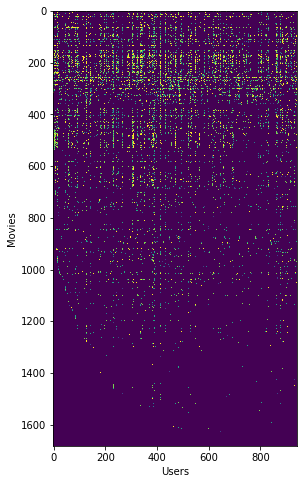

In [523]:
movie1_rated = np.where(R[0, :] == 1)
average = np.mean(Y[0, movie1_rated])
print('Average rating for movie 1 (Toy Story):' + str(average))

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
plt.show()

编写CostFunction函数
编写压缩和解压向量的函数

In [524]:
def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))

def deserialize(num_users, num_movies, num_features, seq):

    return seq[:num_movies * num_features].reshape(num_movies, num_features),\
           seq[num_movies * num_features:].reshape(num_users, num_features)

def cost(Theta, Y, R, lamda, num_users, num_movies, num_features):
    X, theta = deserialize(num_users, num_movies, num_features, Theta)
    
    first = 0.5 * np.sum(((X @ theta.T - Y ) * R) **2)
    print(np.sum(X ** 2))
    second = lamda * (np.sum(theta ** 2) + np.sum(X ** 2)) / 2
    return first + second

#测试函数功能
# num_users = 4
# num_movies = 5
# num_features = 3
# X = X[0:num_movies, 0:num_features]
# theta = theta[0:num_users, 0:num_features]
# Theta = serialize(X, theta)
# Y = Y[0:num_movies, 0:num_users]
# R = R[0:num_movies, 0:num_users]
# J = cost(Theta, Y, R, 1.5, num_users, num_movies, num_features)
# print(J)

编写gradient函数
编写测试gradient正确与否的gradientchecking函数

In [525]:
def gradient(Theta, Y, R, lamda, num_users, num_movies, num_features):
    X, theta = deserialize(num_users, num_movies, num_features, Theta)
    hah = ((X @ theta.T - Y) * R).T
    X_grad = ((X @ theta.T - Y) * R) @ theta + lamda * X
    theta_grad = ((X @ theta.T - Y) * R).T @ X + lamda * theta
    grad = serialize(X_grad, theta_grad)
    return grad

def GradientChecking(Theta, Y, R, lamda, num_users, num_movies, num_features):
    grad = gradient(Theta, Y, R, lamda, num_users, num_movies, num_features)
    
    numgrid = np.zeros(len(Theta))
    perturb = np.zeros(len(Theta))
    epsilon = 1e-4
    for p in range(len(Theta)):
        perturb[p] = epsilon
        loss1 = cost(Theta + perturb, Y, R, lamda, num_users, num_movies, num_features)
        loss2 = cost(Theta - perturb, Y, R, lamda, num_users, num_movies, num_features)
        numgrid[p] = (loss1 - loss2) / (2*epsilon)
        perturb[p] = 0
    diff = np.linalg.norm(numgrid-grad) / np.linalg.norm(numgrid+grad);
    print(grad)
    print(numgrid)
    print(diff)
    
#编写检验gradient和checkgradient函数
# X_test = np.random.random((4,3))
# theta_test = np.random.random((5,3))
# Theta_test = serialize(X_test, theta_test)
# 
# X_t = np.random.random((4,3))
# theta_t = np.random.random((5,3))
# Y_test = X_t @ theta_t.T
# Y_test[np.where(np.random.random(Y_test.shape) > 0.5)]  = 0
# R_test = np.zeros(Y_test.shape)
# R_test[np.where(Y_test != 0)] = 1
# 
# num_users = theta_t.shape[0]
# num_movies = X_t.shape[0]
# num_features = X_t.shape[1]
# 
# GradientChecking(Theta_test, Y_test, R_test, 1.5, num_users, num_movies, num_features)

编写normalize函数

In [526]:
def normalizeRatings(Y, R):
    Ymean = np.zeros((Y.shape[0], 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx], axis=0)
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ynorm, Ymean
        
    
#测试函数功能
# Ynorm, Ymean = normalizeRatings(Y, R)
# print(Ymean)

训练推荐系统

In [527]:
ratings = np.zeros(X.shape[0])
ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5
print('New user ratings:\n')
for i in range(ratings.shape[0]):
    if ratings[i] > 0 :
        print('Rated %d for %s\n' % (ratings[i], movie_list[i]))

Y_movie = np.column_stack((ratings.T, Y))
R_movie = np.column_stack((ratings.T != 0, R))
Ynorm, Ymean = normalizeRatings(Y_movie, R_movie)
num_users = Y_movie.shape[1]
num_movies = Y_movie.shape[0]
num_features = 10
X_movie = np.random.random((num_movies, num_features))
theta_movie = np.random.random((num_users, num_features))
Theta_movie = serialize(X_movie, theta_movie)
res = opt.minimize(fun= cost, x0= Theta_movie, args= (Ynorm, R_movie, 10, num_users, num_movies, num_features),
                   method='TNC', jac=gradient, options={'maxiter': 100})
Theta_final = res.x
X_final, theta_final = deserialize(num_users, num_movies, num_features, Theta_final)
print(X_final.shape)
print(theta_final.shape)

New user ratings:

Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gump (1994)

Rated 2 for Silence of the Lambs, The (1991)

Rated 4 for Alien (1979)

Rated 5 for Die Hard 2 (1990)

Rated 5 for Sphere (1998)

5572.038342157883
5572.038340646608
5572.038341949973
4573.996203391423
4573.996198114059
4573.99620134305
3800.1422664871598
2679.755849769782
2667.265044002652
3090.532651713451
3090.532671037295
3090.532646378553
3090.5326470119285
3090.5326477323974
3090.532647426948
3090.5326449838512
3090.5326470359496
3090.5326490964435
3090.532626949215
484.9378167052302
484.9377985582016
484.9378161146495
430.77336687234975
430.773360161988
430.7733622536964
430.7733667247872
430.77337563722006
1408.6089252174304
661.0296990900473
481.2361712424878
481.23620057530826
481.2361647813731
481.236174

开始进行推荐

In [528]:
X_final = np.matrix(X_final)
theta_final = np.matrix(theta_final)
p = X_final * theta_final.T
my_predictions = p[:, 0] + Ymean
#把matrix变成array
my_predictions =  my_predictions.A1
r = sorted(my_predictions, reverse= True)
ix = np.argsort(-my_predictions, axis=0)

print('Top 10 recommendations for you:\n')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s\n' % (my_predictions[j], movie_list[j]))

print('Original ratings provided:\n')
for i in range(len(ratings)):
    if ratings[i] > 0:
        print('Rated %d for %s\n' % (ratings[i], movie_list[i]))


<class 'numpy.ndarray'>
[1535 1598 1188 ... 1333 1324 1319]
Top 10 recommendations for you:

Predicting rating 5.0 for movie Aiqing wansui (1994)

Predicting rating 5.0 for movie Someone Else's America (1995)

Predicting rating 5.0 for movie Prefontaine (1997)

Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)

Predicting rating 5.0 for movie They Made Me a Criminal (1939)

Predicting rating 5.0 for movie Great Day in Harlem, A (1994)

Predicting rating 5.0 for movie Star Kid (1997)

Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)

Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 

Predicting rating 5.0 for movie Santa with Muscles (1996)

Original ratings provided:

Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gu